# Machine Learning porous permeability from Minkowski Tensors #

Data is first read from the permeability obtain by fitting 2nd order polynomials to the pressure gradient vs velocity curves. 


In [1]:
import matplotlib

# matplotlib.use("pgf")


# matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

import pathlib
import matplotlib.pyplot as pl
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns


import tensorflow as tf
tf.set_random_seed(5)
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

m="m1"
        
def read_dataset(order="m3"):
    X020 = np.loadtxt(order+"/papaya_consolidated/W_020", delimiter=' ')
    print(np.shape(X020))  

    X102 = np.loadtxt(order+"/papaya_consolidated/W_102", delimiter=' ')
    print(np.shape(X102))

    X120 = np.loadtxt(order+"/papaya_consolidated/W_120", delimiter=' ')
    print(np.shape(X120))

    X220 =np.loadtxt(order+"/papaya_consolidated/W_220", delimiter=' ')
    print(np.shape(X220))
    
    X211 = np.loadtxt(order+"/papaya_consolidated/W_211", delimiter=' ')
    print(np.shape(X211))

    Y = np.loadtxt(order+'/fit_coeffs_order_2_4',delimiter=' ')
    print(np.shape(Y))
    return(X020, X102, X120, X220, X211, Y)

X020,X102,X120,X220,X211,Y = read_dataset(m)
column_names =['label','a11','a12','a21','a22','eval1','eval2','eval1by2','evec1x','evec1y','evec2x','evec2y']
W020 = pd.DataFrame(data=X020, columns=column_names)
W102 = pd.DataFrame(data=X102, columns=column_names)
W120 = pd.DataFrame(data=X120, columns=column_names)
W220 = pd.DataFrame(data=X220, columns=column_names)
W211 = pd.DataFrame(data=X211, columns=column_names)
K = pd.DataFrame(data=Y, columns=['inertia','visc','origin'])
K.tail()
K['viscLog']=np.log(K['visc'])
K['inertiaLog']=np.log(K['inertia'])
mu = 0.001
K['Kvisc'] = mu/K['visc'] #darcy permeability
#L = pd.DataFrame(data=length, columns=['length'])
#L.tail()

#featureset = [W020[['eval1','eval2','evec1x','evec1y','evec2x','evec2y']],W102[['eval1','eval2','evec1x','evec1y','evec2x','evec2y']],W120[['eval1','eval2','evec1x','evec1y','evec2x','evec2y']],W220[['eval1','eval2','evec1x','evec1y','evec2x','evec2y']],K[['Kvisc']]]
featureset = [W220[['eval1','eval2','evec1x','evec1y','evec2x','evec2y']],K[['Kvisc']]]
featurenames =['x1','x2','x3','x4','x5','x6','y']
#featurenames =['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','y']
#featureset[0].join(featureset[1:])
featureset = pd.concat(featureset,axis=1)
featureset.tail()
featureset.columns=featurenames
featureset.tail()
featureset_noNa=featureset.dropna()
featureset_excludelow = featureset_noNa[featureset_noNa.x1>0.0]
featureset_excludelow = featureset_excludelow[featureset_excludelow.y>1.0e-1]
featureset_excludelow = featureset_excludelow[featureset_excludelow.y<5.0]
#dataset = featureset_noNa.copy()
dataset = featureset_excludelow.copy()
print(dataset.shape)

1.12.0
(99998, 12)
(99998, 12)
(99998, 12)
(99998, 12)
(99998, 12)
(99998, 3)


/home/prapanch/Software/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


(98576, 7)


In [2]:
dataset.isna().sum()
dataset.tail()
train_dataset = dataset.sample(frac=0.9,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#sns.pairplot(train_dataset[['x1','x2','x3','y']],plot_kws={'alpha':0.3,'linewidth':0})

In [3]:
dataset.tail()

,x1,x2,x3,x4,x5,x6,y
99993,0.422159,0.144386,0.914151,-0.405373,0.405373,0.914151,2.583534
99994,0.394081,0.156388,0.772298,0.635261,-0.635261,0.772298,1.880668
99995,0.367459,0.170202,0.995080,-0.099080,0.099080,0.995080,2.895716
99996,0.389690,0.159437,0.636548,-0.771237,-0.771237,-0.636548,1.413677
99997,0.387985,0.158666,-0.460979,-0.887411,-0.887411,0.460979,0.825095


In [4]:


train_copy = train_dataset.copy()

train_labels = train_dataset.pop('y')

test_labels = test_dataset.pop('y')

std_K = train_labels.std()
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
print(train_stats)

#label_stats = train_labels.describe()
#std_K = float(label_stats['std'])
#std_K = label_stats[['Klog']]
#print(std_K.transpose()['std'])
#label_stats.pop('Klog')
#label_stats = label_stats.transpose()
#print(label_stats)


def norm(x):
    return (x - train_stats['min'])/(train_stats['max']-train_stats['min'])
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
#print(train_labels)
#print((train_dataset.keys()))
print(np.shape(normed_train_data))


      count      mean       std       min       25%       50%       75%  \
x1  88718.0  0.368045  0.069782  0.250662  0.316447  0.357244  0.405776   
x2  88718.0  0.174426  0.032511  0.053567  0.151585  0.174501  0.198424   
x3  88718.0  0.448553  0.552114 -0.707079  0.005555  0.711569  0.909864   
x4  88718.0 -0.438949  0.548909 -1.000000 -0.901734 -0.697709  0.008025   
x5  88718.0 -0.440093  0.547992 -1.000000 -0.901734 -0.698479  0.008662   
x6  88718.0  0.451142  0.550000 -0.707099  0.014091  0.711569  0.909864   

         max  
x1  0.939181  
x2  0.252808  
x3  1.000000  
x4  0.707082  
x5  0.707106  
x6  1.000000  
(88718, 6)


In [5]:
def build_model(options):
    model = keras.Sequential([
        layers.Dense(l1, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())]),
        #layers.Dense(32, activation=tf.nn.tanh),
        layers.Dense(l2, activation=tf.nn.tanh),
        layers.Dense(l3, activation=tf.nn.tanh),
        #layers.Dense(l2, activation=tf.nn.sigmoid),
        #layers.Dense(l3, activation=tf.nn.relu),
        layers.Dense(l4, activation=tf.nn.tanh),
        #layers.Dense(l4, activation=tf.nn.tanh),
        #layers.Dense(l4, activation=tf.nn.tanh),
        #layers.Dense(l4, activation=tf.nn.tanh),
        #layers.Dense(l5, activation=tf.nn.tanh),
        #layers.Dense(l4, activation=tf.nn.tanh),
        #layers.Dense(l4, activation=tf.nn.tanh),
        #layers.Dense(l4, activation=tf.nn.tanh),
        layers.Dense(l6, activation=tf.nn.tanh),
        #layers.Dense(l6, activation=tf.nn.tanh),
        #layers.Dense(l6, activation=tf.nn.tanh),
        #layers.Dense(l7, activation=tf.nn.tanh),
        layers.Dense(l8, activation = tf.nn.tanh),
        ##layers.Dense(l1, activation = tf.nn.tanh),
        layers.Dense(l9, activation = tf.nn.tanh),
        layers.Dense(l10, activation = tf.nn.tanh),
        layers.Dense(1)
    ])

    if(options['optimizer']=='Adam'):
        optimizer = tf.keras.optimizers.Adam(0.005)
    elif(options['optimizer']=='rmsprop'):
        optimizer = tf.keras.optimizers.RMSprop(0.001)
    elif(options['optimizer']=='SGD'):
        optimizer = tf.keras.optimizers.SGD(lr=0.005)
    else:
        optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss = options['lossfunc'],
                 optimizer = optimizer,
                 metrics=['mean_absolute_error','mean_squared_error'])
    return model
l1=6
l2=12


l3=24
l4=48
l5=136
l6=72
#l7=10
l8=32
l9=4
l10=1
#options = {'optimizer':'SGD', 'lossfunc':'mean_squared_error',}
options = {'optimizer':'SGD', 'lossfunc':'mean_squared_error',}
model= build_model(options)
model.summary()
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_3 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_4 (Dense)              (None, 72)                3528      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2336      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
__________

array([[-0.69563293],
       [-0.6600239 ],
       [-0.73063624],
       [-0.5143615 ],
       [-0.6871915 ],
       [-0.55421364],
       [-0.2612383 ],
       [-0.6955865 ],
       [-0.72439784],
       [-0.71202666]], dtype=float32)

In [6]:
 # Display training progress by printing a single dot for each completed epoch
 class PrintDot(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs):
     if epoch % 1000 == 0: print(''+str(epoch))
     if epoch % 100==0: print('.', end='')
 es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=1000)
 EPOCHS = 1000

 history = model.fit(
   normed_train_data, train_labels,
   epochs=EPOCHS, validation_split = 0.1, verbose=0,
   callbacks=[PrintDot(),es])
 hist = pd.DataFrame(history.history)
 hist['epoch'] = history.epoch
 #save history object
 # hist_json_file = "history_"+m+".json"
 # with open(hist_json_file, mode='w') as f:
 #     hist.to_json(f)

 hist_csv_file = "history_study.csv"
 with open(hist_csv_file, mode='w') as f:
     hist.to_csv(f)  



0.003456561645997299


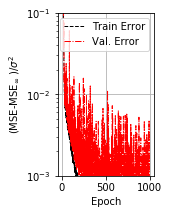

In [12]:
#matplotlib.use("pgf")


#matplotlib.rcParams.update({
#   "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})
#hist.tail()
def plot_history(hist,width):
    #  hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    # pl.figure(figsize=(width/3.0,2.5))
    #   pl.xlabel('Epoch')
    #   pl.ylabel('Mean Abs Error [K]')
    #   pl.plot(hist['epoch'], hist['mean_absolute_error'],
    #            label='Train Error')
    #   pl.plot(hist['epoch'], hist['val_mean_absolute_error'],
    #            label = 'Val Error')
    #   pl.ylim([0,0.5])
    #   pl.legend()

    pl.figure(figsize=(width*0.32,3))
    pl.xlabel('Epoch')
    pl.ylabel('(MSE-MSE$_\infty$ )/$\sigma^2$')
    mean_final_error = np.min(hist['val_mean_squared_error'])
    print(mean_final_error)
    pl.plot(hist['epoch'], (hist['mean_squared_error']-mean_final_error)/std_K**2,'k--',linewidth=1,
           label='Train Error')
    pl.plot(hist['epoch'], (hist['val_mean_squared_error']-mean_final_error)/std_K**2,'r-.',linewidth=1,
           label = 'Val. Error')
    
    #pl.xlim([0,500])
    pl.ylim([0.001,0.1])
    pl.legend()
    pl.grid()
    #pl.savefig("New"+options['optimizer']+"_"+options['lossfunc']+"_"+str(l1)+"_"+str(l2)+"_"+str(l3)+"_"+str(l4)+"_"+str(l5)+"_"+str(l6)+"_"+str(l7)+"_tanh.pdf")
#    pl.show()
#    pl.savefig("learning_m1_transf.pgf",bbox_inches='tight',dpi=300)
    pl.savefig("learning_m1_transf_semi.pdf",bbox_inches='tight',dpi=300)

    pl.show()


#std_KK = std_K.transpose()['std']['K']
#print(std_KK)
pagewidth=5.4 #inches
history = pd.read_csv("history_m1.csv")
plot_history(history,pagewidth)
